In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

In [4]:
# Path
data_dir = 'GTSRB/'

train_csv_path = os.path.join(data_dir, 'Train.csv')
test_csv_path = os.path.join(data_dir, 'Test.csv')

train_df = pd.read_csv(train_csv_path, sep=',')
test_data = pd.read_csv(test_csv_path, sep=',')

train_df['Path'] = train_df['Path'].apply(lambda x: os.path.join(data_dir, x))
test_data['Path'] = test_data['Path'].apply(lambda x: os.path.join(data_dir, x))

In [5]:
from sklearn.model_selection import train_test_split

# Splitting train into train and val
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Wyświetlenie liczby przykładów w każdym zbiorze
print("Size of training dataset:", len(train_data))
print("Size of validation dataset:", len(val_data))
print("Size of test dataset:", len(test_data))

Size of training dataset: 31367
Size of validation dataset: 7842
Size of test dataset: 12630


In [6]:
train_data

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
35502,36,37,6,6,31,32,36,GTSRB/Train/36/00036_00003_00013.png
31160,50,47,5,6,45,42,28,GTSRB/Train/28/00028_00011_00020.png
3489,32,33,5,6,27,28,2,GTSRB/Train/2/00002_00023_00009.png
9288,45,39,5,5,40,34,5,GTSRB/Train/5/00005_00028_00018.png
29987,51,50,6,6,46,45,26,GTSRB/Train/26/00026_00000_00017.png
...,...,...,...,...,...,...,...,...
6265,42,42,6,5,37,37,3,GTSRB/Train/3/00003_00040_00025.png
11284,30,27,6,6,25,22,7,GTSRB/Train/7/00007_00019_00004.png
38158,117,119,11,11,107,109,39,GTSRB/Train/39/00039_00002_00029.png
860,46,45,5,5,41,40,1,GTSRB/Train/1/00001_00009_00020.png


In [7]:
val_data

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
30003,42,40,6,6,37,35,26,GTSRB/Train/26/00026_00001_00003.png
23050,55,62,6,5,49,57,14,GTSRB/Train/14/00014_00014_00010.png
21060,35,32,6,6,30,27,13,GTSRB/Train/13/00013_00020_00000.png
15561,45,45,6,6,40,40,10,GTSRB/Train/10/00010_00017_00021.png
23655,46,47,5,6,41,42,15,GTSRB/Train/15/00015_00008_00015.png
...,...,...,...,...,...,...,...,...
14107,32,33,5,6,27,28,9,GTSRB/Train/9/00009_00018_00007.png
20129,131,106,12,9,120,97,12,GTSRB/Train/12/00012_00058_00029.png
12389,65,64,6,5,60,59,8,GTSRB/Train/8/00008_00007_00029.png
10906,45,46,5,6,40,41,7,GTSRB/Train/7/00007_00006_00016.png


In [8]:
test_data

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,GTSRB/Test/00000.png
1,42,45,5,5,36,40,1,GTSRB/Test/00001.png
2,48,52,6,6,43,47,38,GTSRB/Test/00002.png
3,27,29,5,5,22,24,33,GTSRB/Test/00003.png
4,60,57,5,5,55,52,11,GTSRB/Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,GTSRB/Test/12625.png
12626,50,51,6,5,45,46,33,GTSRB/Test/12626.png
12627,29,29,6,6,24,24,6,GTSRB/Test/12627.png
12628,48,49,5,6,43,44,7,GTSRB/Test/12628.png


## Preprocess

In [9]:
IMG_SIZE = 32 

def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalization
    return image

In [10]:
def prepare_dataset_simple(dataframe):
    # Paths to images and labels
    image_paths = dataframe['Path'].values
    labels = dataframe['ClassId'].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    dataset = dataset.map(lambda x, y: (process_image(x), y),
                          num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Tworzenie datasetów
train_dataset = prepare_dataset_simple(train_data)
val_dataset = prepare_dataset_simple(val_data)
test_dataset = prepare_dataset_simple(test_data)

In [11]:
len(train_dataset), len(val_dataset), len(test_dataset)

(981, 246, 395)

In [12]:
## Few random images

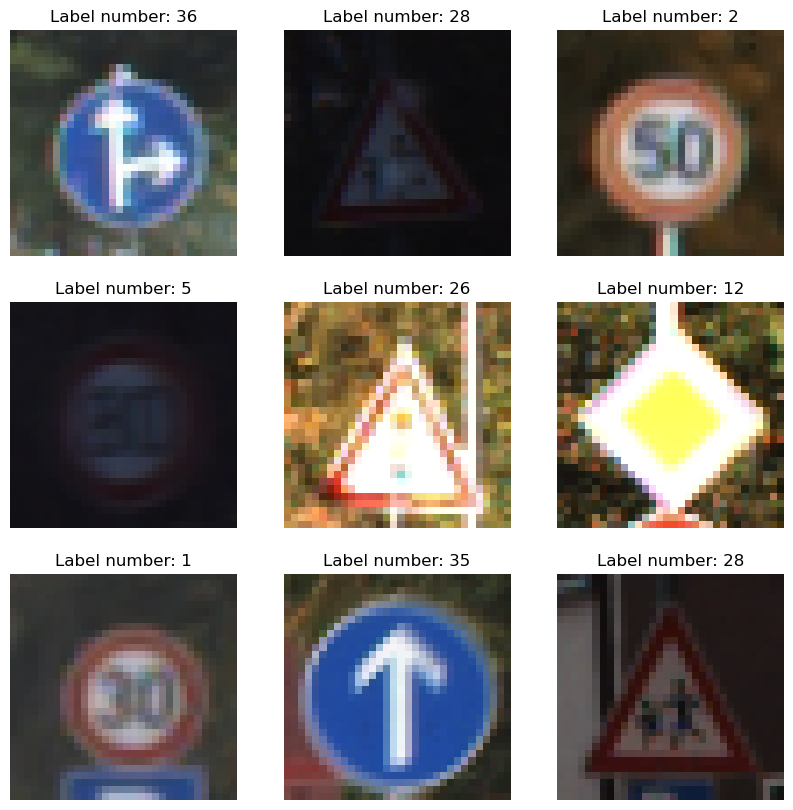

In [13]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Label number: {}".format(int(labels[i])))
        plt.axis("off")

## Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2

num_classes = train_df['ClassId'].nunique()  # All classes

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.5), 
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True, mode='min')

checkpoint_cb = ModelCheckpoint(
    'model_v1',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

epochs = 20

history = model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=val_dataset,
    callbacks=[checkpoint_cb, early_stopping_callback]
)

Epoch 1/20
981/981 [==============================] - ETA: 0s - loss: 2.0152 - accuracy: 0.4371

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 14s 11ms/step - loss: 2.0152 - accuracy: 0.4371 - val_loss: 0.6519 - val_accuracy: 0.8410
Epoch 2/20
972/981 [============================>.] - ETA: 0s - loss: 0.8368 - accuracy: 0.7478

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.8358 - accuracy: 0.7483 - val_loss: 0.3336 - val_accuracy: 0.9287
Epoch 3/20
975/981 [============================>.] - ETA: 0s - loss: 0.5924 - accuracy: 0.8323

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 11ms/step - loss: 0.5921 - accuracy: 0.8323 - val_loss: 0.2327 - val_accuracy: 0.9665
Epoch 4/20
977/981 [============================>.] - ETA: 0s - loss: 0.4688 - accuracy: 0.8798

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.4688 - accuracy: 0.8797 - val_loss: 0.1948 - val_accuracy: 0.9802
Epoch 5/20
981/981 [==============================] - 8s 9ms/step - loss: 0.3987 - accuracy: 0.9066 - val_loss: 0.2029 - val_accuracy: 0.9772
Epoch 6/20
980/981 [============================>.] - ETA: 0s - loss: 0.3553 - accuracy: 0.9226

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.3553 - accuracy: 0.9227 - val_loss: 0.1722 - val_accuracy: 0.9888
Epoch 7/20
974/981 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.9378

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.3156 - accuracy: 0.9378 - val_loss: 0.1715 - val_accuracy: 0.9903
Epoch 8/20
981/981 [==============================] - 9s 9ms/step - loss: 0.2941 - accuracy: 0.9455 - val_loss: 0.1800 - val_accuracy: 0.9895
Epoch 9/20
981/981 [==============================] - 9s 9ms/step - loss: 0.2746 - accuracy: 0.9546 - val_loss: 0.1733 - val_accuracy: 0.9917
Epoch 10/20
972/981 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9593

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.2600 - accuracy: 0.9591 - val_loss: 0.1709 - val_accuracy: 0.9911
Epoch 11/20
975/981 [============================>.] - ETA: 0s - loss: 0.2458 - accuracy: 0.9636

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.2457 - accuracy: 0.9637 - val_loss: 0.1659 - val_accuracy: 0.9929
Epoch 12/20
981/981 [==============================] - 9s 9ms/step - loss: 0.2319 - accuracy: 0.9688 - val_loss: 0.1710 - val_accuracy: 0.9917
Epoch 13/20
981/981 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9709

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.2269 - accuracy: 0.9709 - val_loss: 0.1653 - val_accuracy: 0.9932
Epoch 14/20
981/981 [==============================] - 9s 9ms/step - loss: 0.2158 - accuracy: 0.9746 - val_loss: 0.1669 - val_accuracy: 0.9923
Epoch 15/20
976/981 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9765

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.2078 - accuracy: 0.9764 - val_loss: 0.1557 - val_accuracy: 0.9946
Epoch 16/20
981/981 [==============================] - 8s 8ms/step - loss: 0.2054 - accuracy: 0.9768 - val_loss: 0.1575 - val_accuracy: 0.9938
Epoch 17/20
974/981 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.9777

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.1992 - accuracy: 0.9778 - val_loss: 0.1512 - val_accuracy: 0.9946
Epoch 18/20
981/981 [==============================] - 9s 9ms/step - loss: 0.1954 - accuracy: 0.9789 - val_loss: 0.1575 - val_accuracy: 0.9938
Epoch 19/20
974/981 [============================>.] - ETA: 0s - loss: 0.1852 - accuracy: 0.9813

INFO:tensorflow:Assets written to: model_v1\assets


INFO:tensorflow:Assets written to: model_v1\assets


981/981 [==============================] - 10s 10ms/step - loss: 0.1850 - accuracy: 0.9814 - val_loss: 0.1476 - val_accuracy: 0.9953
Epoch 20/20
981/981 [==============================] - 9s 9ms/step - loss: 0.1858 - accuracy: 0.9814 - val_loss: 0.1480 - val_accuracy: 0.9945


## History plots

246/246 [==============================] - 1s 5ms/step - loss: 0.1480 - accuracy: 0.9945

Val accuracy: 0.9945167303085327


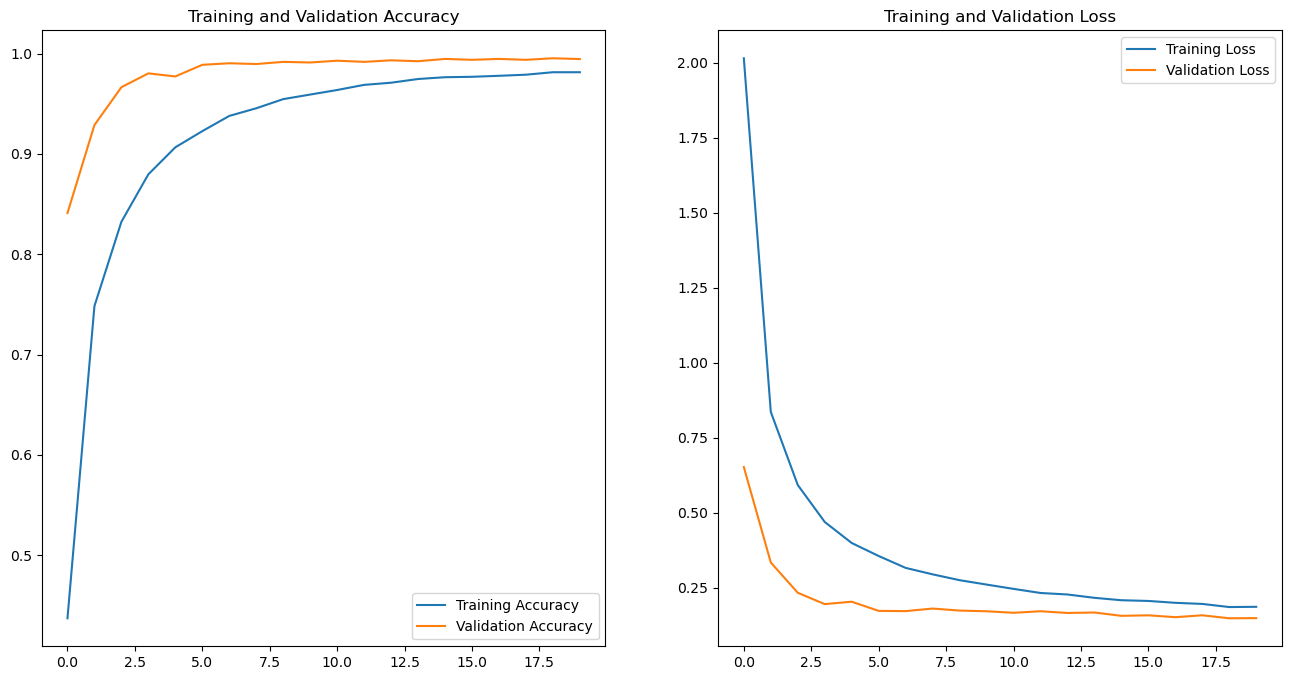

In [27]:
# Validation dataset re-check
loss, acc = model.evaluate(val_dataset)
print(f'\nVal accuracy: {acc}')

# History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.evaluate(test_dataset)

395/395 [==============================] - 2s 6ms/step - loss: 0.3474 - accuracy: 0.9596


[0.34740909934043884, 0.95961993932724]

## Load best and evaluate

In [19]:
from tensorflow.keras.models import load_model

# Load best model
best_model = load_model('model_v1')

# Evaluate again
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f'\nTest accuracy of the best model: {test_acc}')

395/395 [==============================] - 2s 5ms/step - loss: 0.3494 - accuracy: 0.9573

Test accuracy of the best model: 0.9573238492012024


In [20]:
y_pred_probs = best_model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(y_pred_probs, axis=1)

n_classes = y_pred_probs.shape[1]  # liczba klas

395/395 [==============================] - 2s 5ms/step


### Confusion matrix

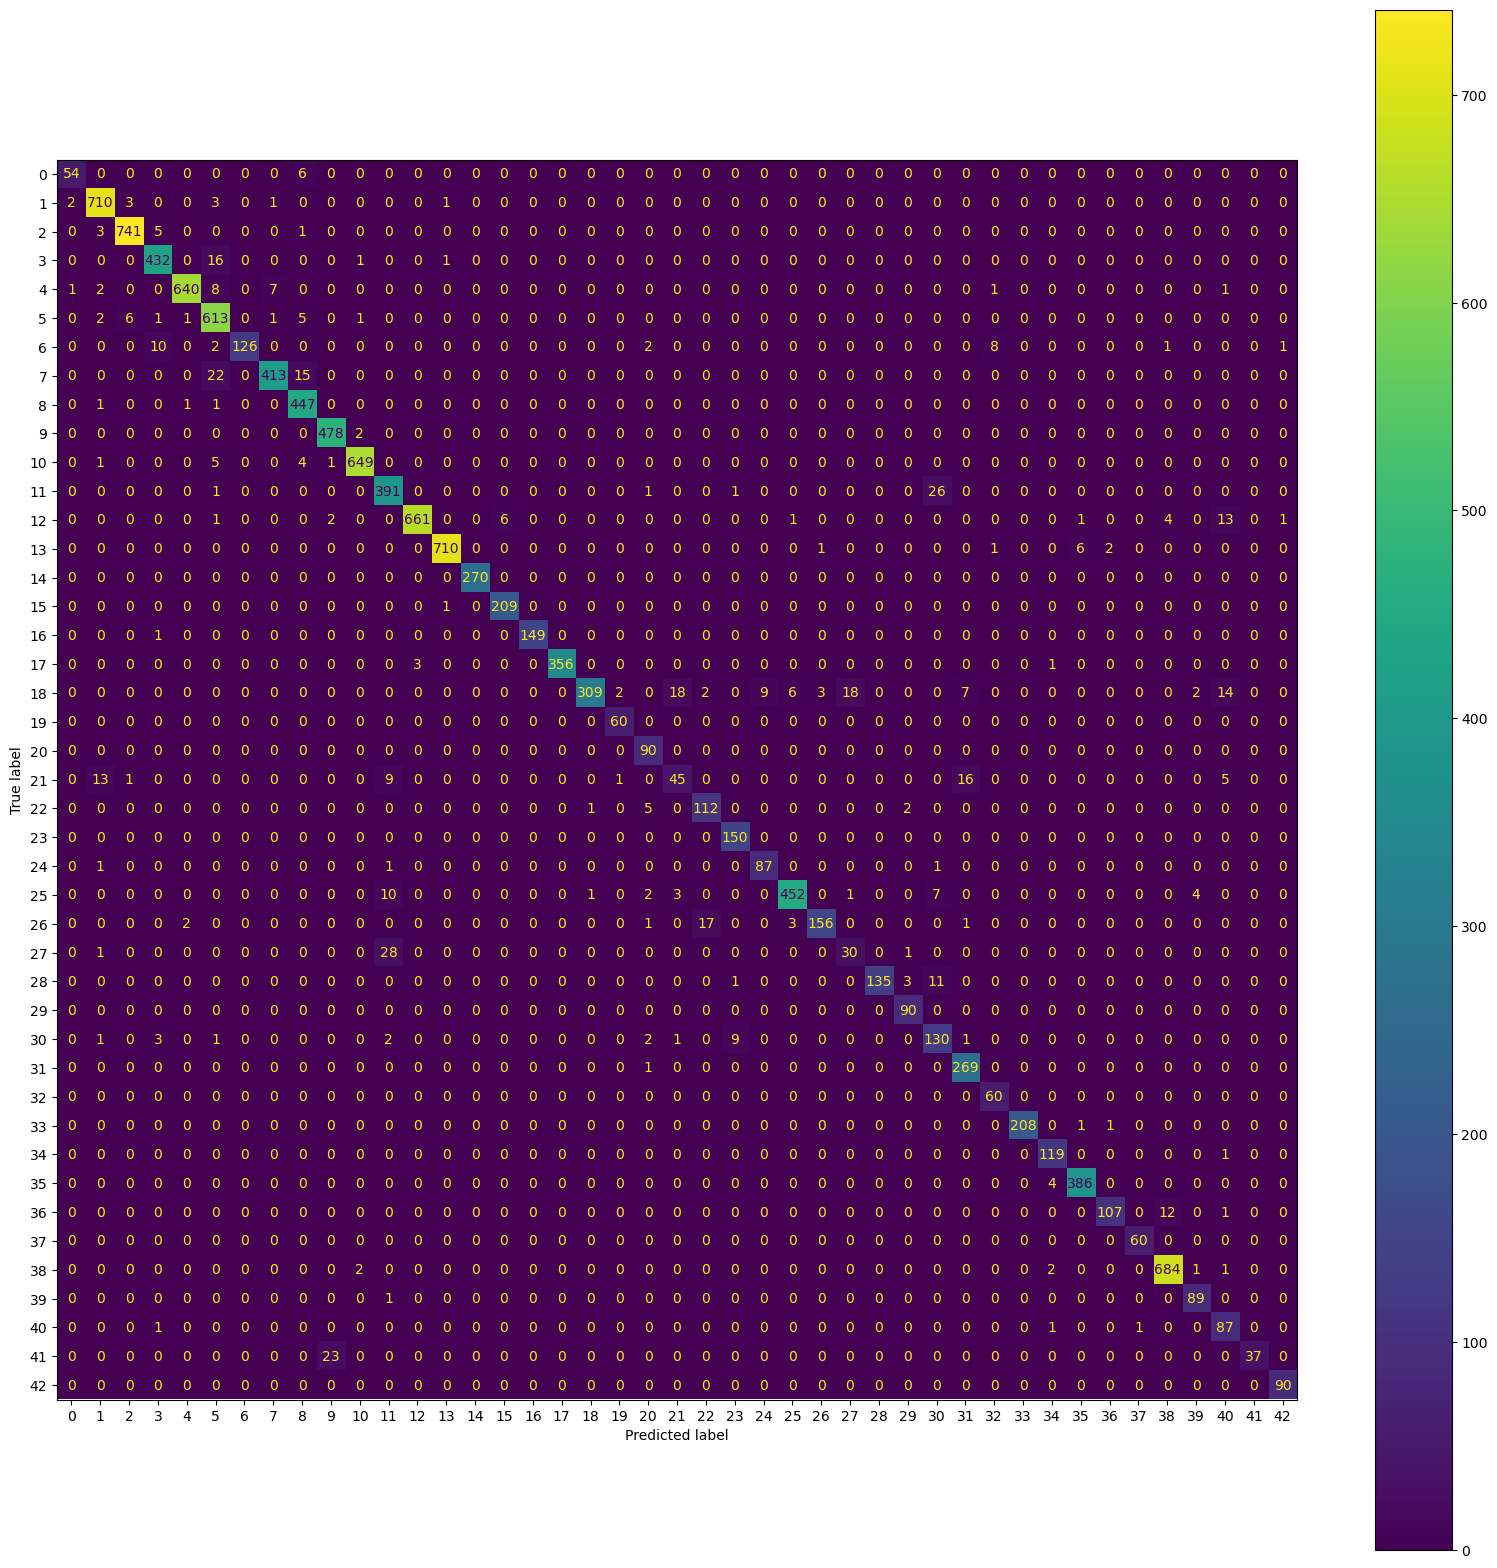

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Conf matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.show()

### ROC curve

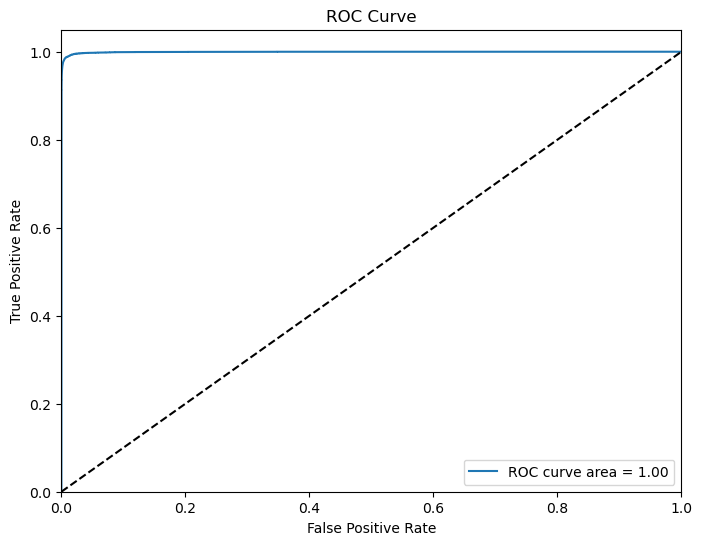

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels
y_true_binarized = label_binarize(y_true, classes=range(n_classes))

# ROC/AUC
fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve area = {0:0.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Precision-recall curve

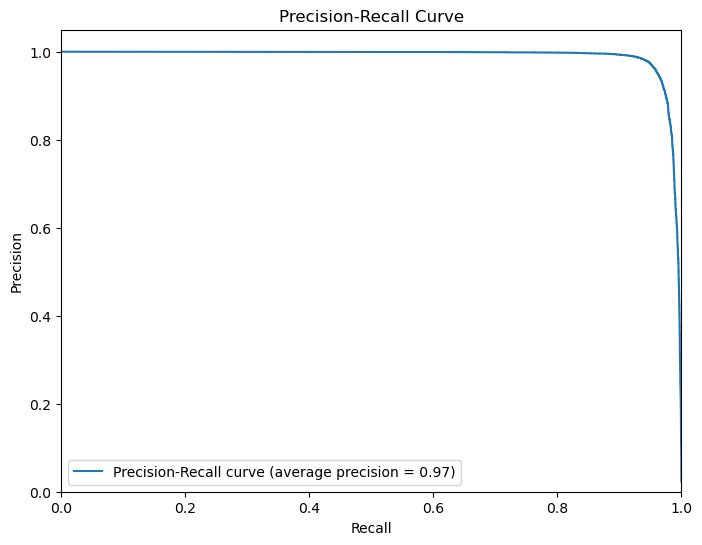

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])

# Precision and recall for all classes
precision["macro"], recall["macro"], _ = precision_recall_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
average_precision["macro"] = average_precision_score(y_true_binarized, y_pred_probs, average="macro")

# Rysowanie krzywej Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall['macro'], precision['macro'], label='Precision-Recall curve (average precision = {0:0.2f})'.format(average_precision['macro']))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Random predictions

1/1 [==============================] - 0s 307ms/step


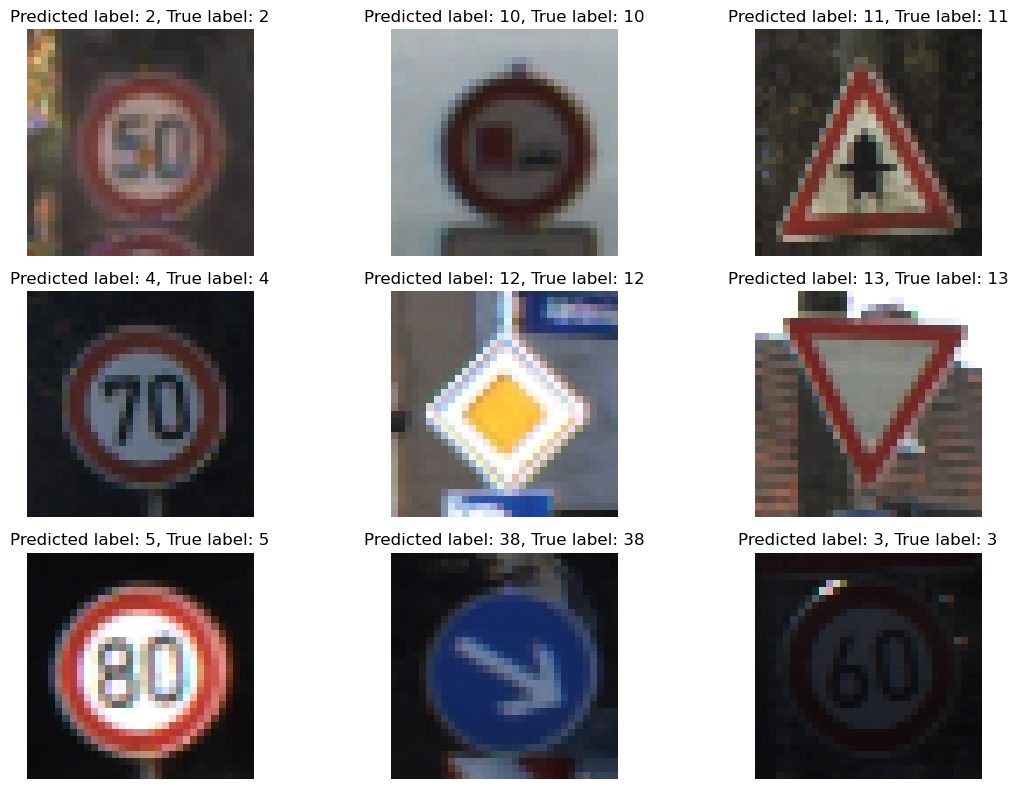

In [24]:
all_test_images = []
all_test_labels = []

for images, labels in test_dataset.unbatch(): 
    all_test_images.append(images.numpy())
    all_test_labels.append(labels.numpy())

all_test_images = np.array(all_test_images)
all_test_labels = np.array(all_test_labels)

# Random 9 predictions
random_indices = np.random.choice(all_test_images.shape[0], size=9, replace=False)

random_test_images = all_test_images[random_indices]
random_test_labels = all_test_labels[random_indices]

predicted_probs = best_model.predict(random_test_images)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Plot
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_test_images[i])
    plt.title(f"Predicted label: {predicted_labels[i]}, True label: {random_test_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Random BAD predictions

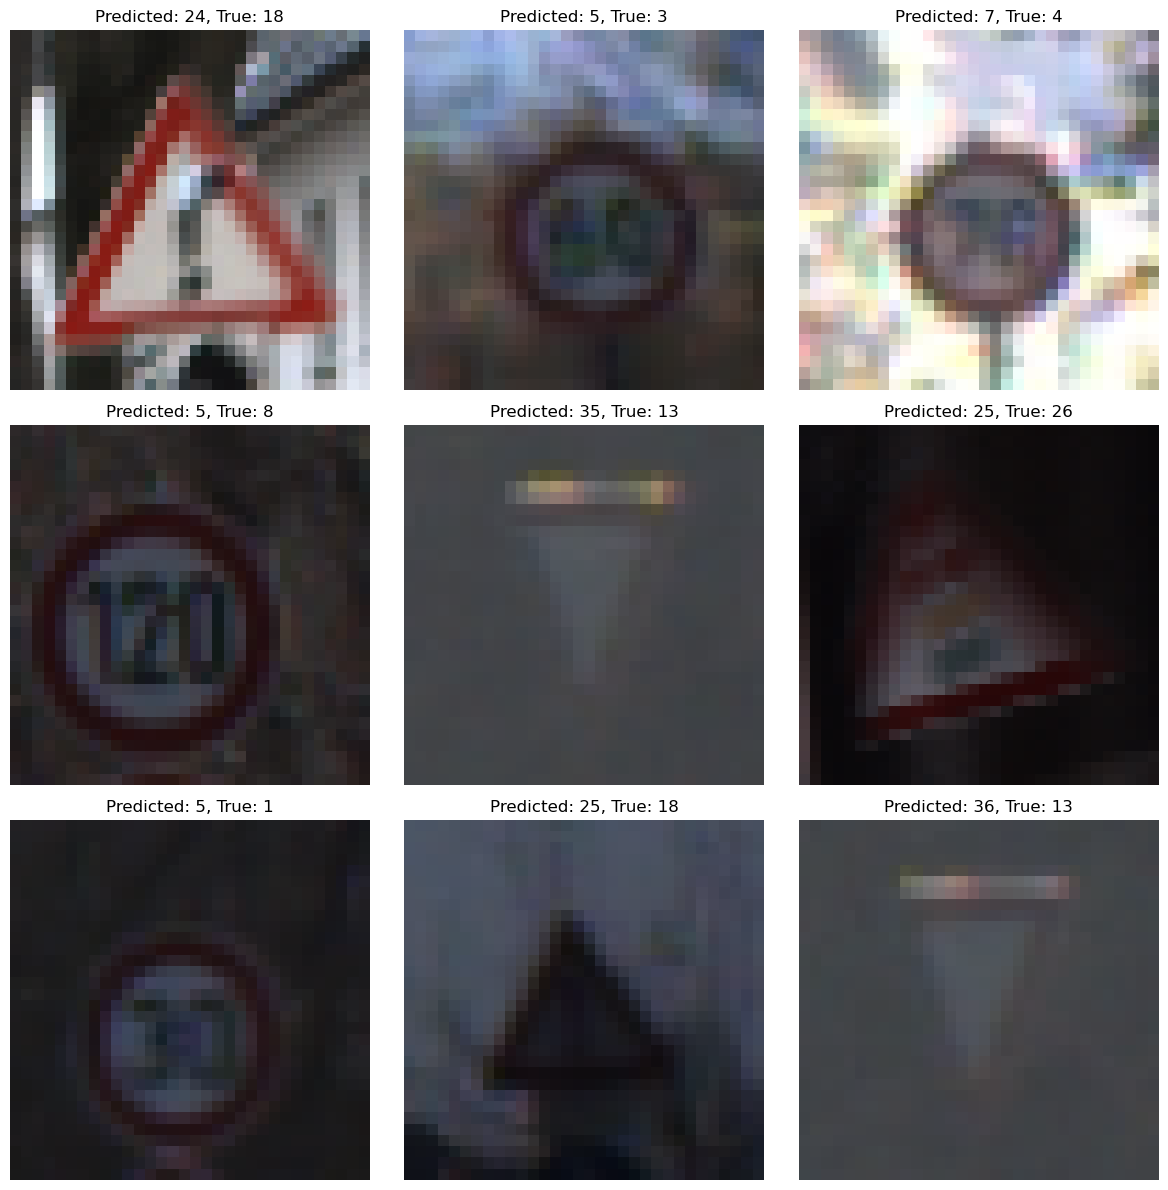

In [25]:
# Looking for examples od bad predictions
misclassified_indices = np.where(y_pred != all_test_labels)[0]

# Random 9 bad predictions
random_misclassified_indices = np.random.choice(misclassified_indices, size=9, replace=True)

# Plot
plt.figure(figsize=(12, 12))
for i, index in enumerate(random_misclassified_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_test_images[index])
    plt.title(f'Predicted: {y_pred[index]}, True: {all_test_labels[index]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Accuracy/Precision/Recall/F1

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true and y_pred are defined
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9573238321456848
Precision: 0.9590536679876326
Recall: 0.9573238321456848
F1 Score: 0.956750781594594
